In [1]:
import gym
import random
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Activation, Permute, Dense, Dropout, Conv2D, Input, Lambda, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import keras.backend as K
import cv2

Using TensorFlow backend.


In [2]:
from wrappers import  wrap_dqn

In [3]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

# Agent

In [4]:
def huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true,y_pred)

class Agent():
       
    def __init__(self, state_size, action_size, weights=None):
        
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.model = self.build_model()
        self.memory = deque(maxlen=1000000)
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = (1-0.01) / 1000000
        self.gamma = 0.99
        self.target_model = self.build_model()
        self.next_target_update = 10000
        self.nb_do_nothing = 0
        if weights != None:
            print("ok")
            self.model.load_weights(weights)
            self.target_model.load_weights(weights)
        self.current_state = []
    
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)
        
    def build_model(self):       
        
        input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
        model = Sequential()

        # (width, height, channels)
        model.add(Permute((2, 3, 1), input_shape=input_shape))
        model.add(Conv2D(32, (8, 8), strides=(4, 4)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (4, 4), strides=(2, 2)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dense(self.action_size))
        model.add(Activation('linear'))
        print(model.summary())
        #model.summary()
        
        model.compile(RMSprop(lr=.00025, rho=0.95), loss='mae')
        
        return model
    
        
    def next_action(self, current_state):
        batch = self.process_state_batch(np.expand_dims(current_state, axis=0))
        q_values = self.model.predict(batch)[0]
        
        if self.nb_do_nothing > 29:
            if np.random.rand() <= self.exploration_rate:
                action = random.randrange(self.action_size - 1) + 1  
            else:
                action = np.argmax(q_values[1:])
                
        else:
            if np.random.rand() <= self.exploration_rate:
                action = random.randrange(self.action_size)  
            else:
                action = np.argmax(q_values)
        if action == 0:
            self.nb_do_nothing +=1
            
        return action, np.max(q_values)
    

    def update_frames(self, frames, next_frame):
        return np.vstack((frames[1:,:,:], [next_frame]))
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        batch_states, batch_target = [], []
        if len(self.memory) < batch_size:
                return
        sample_batch = random.sample(self.memory, batch_size)
        for current_state, action, reward, next_state, done in sample_batch:
            state = self.process_state_batch(np.expand_dims(current_state, axis=0))
            target = self.target_model.predict(state)
            
            next_batch = self.update_frames(current_state, next_state)
            next_batch = self.process_state_batch(np.expand_dims(next_batch, axis=0))
            q_next_state = np.max(self.target_model.predict(next_batch)[0])
            if not done:
                target[0][action] = reward + self.gamma * q_next_state
            else:
                target[0][action] = reward
            batch_states.append(state[0])
            batch_target.append(target[0])
        
        self.model.fit(np.array(batch_states), np.array(batch_target), epochs=1, verbose=0)
        self.decay_exploration_rate()
        

            
    def update_target_model(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] =  weights[i]
        self.target_model.set_weights(target_weights)

                
            
    def decay_exploration_rate(self):
        self.exploration_rate = max(self.exploration_min, self.exploration_rate - self.exploration_decay)
        
    def initialize_memory(self):
        print("initializing memory")
        while len(self.memory) < 50000:
            self.nb_do_nothing = 0
            obs = self.process_observation(env.reset())
            current_state = np.array([obs, obs, obs, obs])
            done = False
            while not done:
                action = random.randrange(self.action_size)
                next_state, reward, done, _ = env.step(action)
                next_state =  self.process_observation(next_state)
                self.remember(current_state, action, reward, next_state, done)
                current_state = self.update_frames(current_state, next_state)
        print("memory initialized")
    
    def learn(self, env, nb_episodes, initialize=True, batch_size=32):
        if initialize:
            self.initialize_memory()
        steps = []
        all_rewards = []
        pbar = tqdm(range(nb_episodes))
        total_steps = 0
        for i in pbar:
            self.nb_do_nothing = 0
            obs = self.process_observation(env.reset())
            current_state = np.array([obs, obs, obs, obs])
            episode_nb_steps = 0
            episode_reward = 0
            episode_sum_q_value = 0
            done = False
            actions = {0:0, 
                      1:0,
                      2:0, 
                      3:0}
            
            
            while not done:
                total_steps += 1
                if total_steps % 10000 == 0:
                    self.update_target_model()
                action, q_value = self.next_action(current_state)
                next_state, reward, done, _ = env.step(action)
                reward = self.process_reward(reward)
                
                actions[action] += 1
                episode_sum_q_value += q_value
                episode_nb_steps += 1
                episode_reward += reward
                
                next_state = self.process_observation(next_state)
                self.remember(current_state, action, reward, next_state, done)
                self.replay(batch_size)
                current_state = self.update_frames(current_state, next_state)
                
            all_rewards.append(episode_reward)
            steps.append(episode_nb_steps)
            for action in actions:
                actions[action] =  str(round(actions[action] / episode_nb_steps * 100, 0)) + "%"
            pbar.set_description("episode: %s, nb_steps_this_episode: %s, reward: %s, exploration: %s, q_value_mean: %s, actions: %s, total_steps: %s" \
                                 % (i, episode_nb_steps, episode_reward, self.exploration_rate, episode_sum_q_value / episode_nb_steps, actions, total_steps))
            if (total_steps + 1) % 250000 == 0:
                path = 'weights/my_dqn_model_weights_' + str(total_steps + 1)
                self.model.save(path)
            
        return steps, all_rewards
     

# Environement

In [5]:
env = gym.make('Breakout-v4')
env  = wrap_dqn(env)
np.random.seed(123)
env.seed(123)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0         
__________

# Training

In [6]:
steps, rewards = agent.learn(env, 100000)
plt.figure(figsize=(20,5))
plt.plot(rewards)

initializing memory
WARN: <class 'wrappers.NoopResetEnv'> doesn't implement 'step' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
memory initialized


episode: 47665, nb_steps_this_episode: 4, reward: 0.0, exploration: 0.5043891700107592, q_value_mean: 0.01410368806682527, actions: {0: '25.0%', 1: '50.0%', 2: '0.0%', 3: '25.0%'}, total_steps: 500617:  48%|████▊     | 47666/100000 [17:48:30<39:59:15,  2.75s/it]

KeyboardInterrupt: 

# Playing

In [6]:
actions = env.unwrapped.get_action_meanings()

In [7]:
def get_heat_map(agent, action, x, state):
    model = agent.model
    
    predictiont_output = model.output[:, action]
    last_conv_layer = model.get_layer('conv2d_3')
    grads = K.gradients(predictiont_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    batch = agent.process_state_batch(np.expand_dims(x, axis=0))
    pooled_grads_value, conv_layer_output_value = iterate([batch])
    for i in range(7):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
   # heatmap = heatmap / np.max(heatmap)
   # print(heatmap)
   # print("")
   # print(pooled_grads_value)
   # print("")
   # print(conv_layer_output_value)
   # print("")
   # print(x)
   # print("")
   # print(np.max(batch))
    heatmap = cv2.resize(heatmap, (160, 210))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + state
    return superimposed_img /255 

In [8]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

def distant_render(env, agent, state_size, nb_steps=200):
    agent.exploration_rate = 0
    state_img = env.reset()
    previous_state = state_img
    img = plt.imshow(state_img)
    state = agent.process_observation(state_img)
    current_state = np.array([state, state, state, state])
    
    done = False
     # only call this once
    #for i in range(nb_steps):
    while not done:
              
        
        action, _ = agent.next_action(current_state)
        
        img.set_data(state_img) # just update the data
        plt.title(actions[action])
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        next_state, reward, done, _ = env.step(action)
        state_img = get_heat_map(agent, action, current_state, previous_state)
        previous_state = next_state
        next_state = agent.process_observation(next_state)
        current_state = agent.update_frames(current_state, next_state)
        if done:
            break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


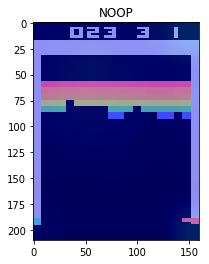

In [ ]:
#agent = Agent(state_size, action_size, weights="./weights/DQN_breakout_model.h5")
distant_render(env, agent, state_size, 400)

In [8]:
agent.model.save_weights("./weights/My_DQN_11-10.h5")